# Week 03 – Unboxing Methods

In this notebook we'll be training a black-box model to the dataset which we will then explain using different post-hoc explanation methods.

If you haven't done so yet, please run the following in your command line so you're able to access the relevant packages: 
```
# navigate to parent directory using cd and activate environment
cd trustworthy_ai
source trustworthy_ai_venv/bin/activate

# install packages
pip install lime shap torch grad-cam

# close environment
deactivate
```
**import packages**

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
import os
import sys
import matplotlib.pyplot as plt
import random

---

# Tabular data – Titanic dataset

## Load the dataset

We are using the Statlog (German Credit Data) dataset (Dheeru Dua and Casey Graff. UCI machine learning repository, 2017. URL [http://archive.ics.uci.edu](http://archive.ics.uci.edu)). The German Credit dataset classifies people described by a set of 20 features as good or bad credit risk.

Make sure to save the dataset in the parent directory or adjust the file path below.

We are directly loading the pre-processed data sets. For some algorithms, we require the data to be in binary form. Hence, we have two versions of X: `X_train` and `X_test`, with continous features and one-hot encoded categorical features, and `X_train_bin` and `X_test_bin`, where all features have been one-hot encoded. For this, continuous features were first transformed into categories. Check the code in `./01_intro/data_prep.ipynb` for more details on pre-processing.

In [2]:
# X_train 
X_train = pd.read_csv('../datasets/titanic/encoded_titanic_X_train.csv')

# X_test
X_test = pd.read_csv('../datasets/titanic/encoded_titanic_X_test.csv')

# y_train and y_test
y_train = pd.read_csv('../datasets/titanic/titanic_y_train.csv')
y_test = pd.read_csv('../datasets/titanic/titanic_y_test.csv')

# take a look at the data
X_train.head()

,Age,SibSp,Parch,Fare,Sex_1,Embarked_1,Embarked_2,Pclass_1,Pclass_2
0,29.699118,0,0,7.6292,0,1,0,0,1
1,29.699118,0,0,8.0500,1,0,1,0,1
2,29.699118,0,0,7.7500,0,1,0,0,1
3,51.000000,1,0,77.9583,0,0,1,0,0
4,21.000000,0,0,7.7333,1,1,0,0,1


In [3]:
# save feature names
feature_names = list(X_train.columns)

# create a dataframe to save y values in 
y_results = pd.DataFrame()
y_results['y_test'] = y_test

---

# 1. Training a black-box model

We will train a complex, uninterpretable model to the dataset. For the sake of this tutorial, we've chosen to train a Gradient Boosting classifier. We'll use `scikit-learn`'s implementation.

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

We are performig grid search and 5-fold cross validation to determine the best combinations of values for the parameters `n_estimators` and `max_depth`, from the set {100,150,200,250,300} and {2,3,5}, respectively.

In [5]:
# performing grid search to find the best parameter values
pgrid = {'n_estimators':[100,150,200,250,300],
        'max_depth':[2,3,5]}

gb = GradientBoostingClassifier(random_state=0)
gcv = GridSearchCV(estimator=gb, param_grid=pgrid, n_jobs=1, cv=5, verbose=1, refit=True)
gcv_fit = gcv.fit(X_train, y_train)
gb = gcv_fit.best_estimator_
y_results['gb_pred'] = gb.predict(X_test)
y_results['gb_pred_prob'] = gb.predict_proba(X_test)[:, 1]
print(gb)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
GradientBoostingClassifier(max_depth=2, random_state=0)


## inspect performance

In [6]:
# Confusion matrix
cm = pd.crosstab(y_results['y_test'], y_results['gb_pred'])
print ("Confusion matrix : \n", cm)

print('\nAccuracy  = %.4f' % accuracy_score(y_results['y_test'], y_results['gb_pred']))
print('F1 score  = %.4f' % f1_score(y_results['y_test'], y_results['gb_pred']))
num_leaves = sum(tree.tree_.n_leaves for tree in gb.estimators_.reshape(-1))           
print('Number of rules = %.0f' % (num_leaves))

Confusion matrix : 
 gb_pred   0   1
y_test         
0        96  14
1        22  47

Accuracy  = 0.7989
F1 score  = 0.7231
Number of rules = 389


### Questions

**Q 1.1 – Which parameters seem to have worked best according to the grid search?**

...

**Q 1.2 – Evaluate the model in terms of performance and interpretability.**

...

---
---
# 2. LIME

Local interpretable model-agnostic explanations (LIME) was proposed by [Ribeiro et al. (2016)](https://dl.acm.org/doi/abs/10.1145/2939672.2939778) and implemented in the package `lime`.

In [7]:
from lime import lime_tabular

In [8]:
# initiate explainer instance
explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), mode='classification',
                                              training_labels=list(y_train['Survived'].unique()),
                                              feature_names = feature_names,random_state=0)

### GLOBAL

LIME does not produce any global explanations as it trains an interpretable model locally around the sample to be explained.

### LOCAL

In [9]:
i = 2
exp_gb = explainer.explain_instance(np.array(X_test.iloc[i,:]), gb.predict_proba, num_features=5)

In [10]:
print(f'True and predicted values for sample at index {i}:')
print(round(y_results.loc[i,:],2))
print('\n')
exp_gb.show_in_notebook(show_table=True)

True and predicted values for sample at index 2:
y_test          0.00
gb_pred         0.00
gb_pred_prob    0.29
Name: 2, dtype: float64




### Questions

**Q 2.1 – Take a look at the local explanation for sample with index 2 of the test set. How would you interpret this explanation?.**

...

---
---

# 3. SHAP

Based on Shapley values from coalitional game theory, SHAP is a model-agnostic method that assigns feature contributions and was introduced by [Lundberg et al. (2017)](https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html). Besides LIME it belongs to the most well known post-hoc explanation methods and is implemented in the package `shap`.

In [11]:
import shap

explainer = shap.TreeExplainer(gb, X_train)
shap_values = explainer(X_test)

### GLOBAL

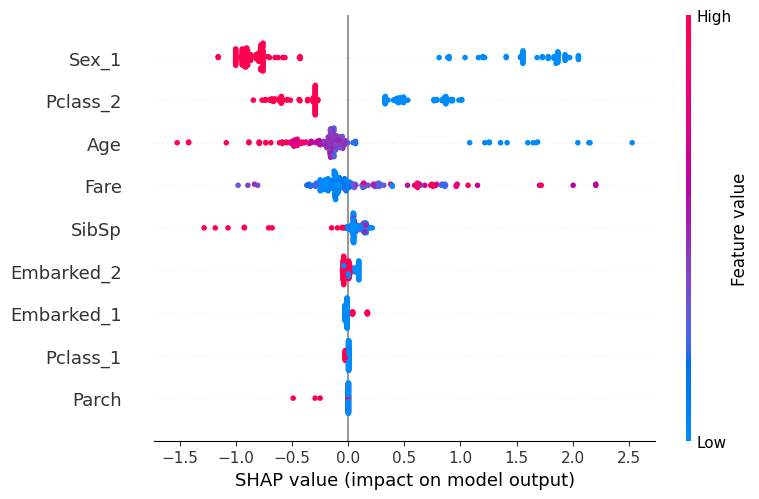

In [12]:
shap.summary_plot(shap_values, X_test)

### Questions

**Q 3.1 – Explain what the summary plot shows and how it can be interpreted.**

...

### LOCAL

There are multiple ways of displaying the feature importances produced by SHAP. Here we show waterfall and force plots.

----
SHAP waterfall plot
----


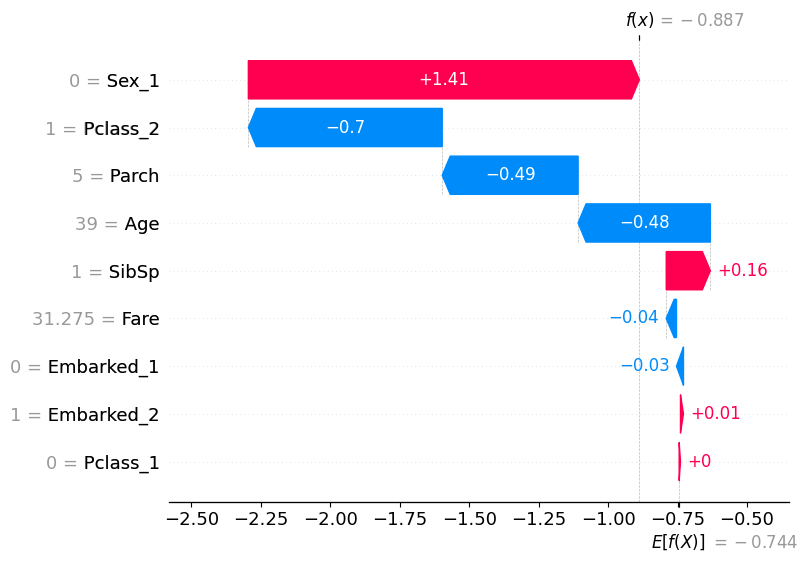

In [13]:
# shap
print('----\nSHAP waterfall plot\n----')
shap.plots.waterfall(shap_values[i,:])

In [14]:
print('----\nSHAP force plot\n----')
shap.initjs()
shap.force_plot(explainer.expected_value,
                              shap_values[i,:].values,
                              X_test.iloc[i,:])


----
SHAP force plot
----


### Questions

**Q 3.1 – Take a look at the waterfall plot and the force plot. Describe what they show, whether they differ in the information they provide and how you can interpret both.**

...

**Q 3.2 – Is there a way to display only some of the features, let's say the top 5? If yes, how?**

...

---
---

# Image data – Fashion MNIST data

# 1. SHAP on images

## Load the data

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [16]:
X_train = pd.read_csv('../datasets/fashion_mnist/fashion_mnist_X_train.csv', dtype = np.float32)
y_train = pd.read_csv('../datasets/fashion_mnist/fashion_mnist_y_train.csv', dtype = np.float32)
X_test = pd.read_csv('../datasets/fashion_mnist/fashion_mnist_X_test.csv', dtype = np.float32)
y_test = pd.read_csv('../datasets/fashion_mnist/fashion_mnist_y_test.csv',dtype = np.float32)

X_train = X_train.values/255
y_train = y_train.values.flatten()
X_test = X_test.values/255
y_test = y_test.values.flatten()


X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).type(torch.LongTensor) # data type is long

X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test).type(torch.LongTensor) # data type is long

batch_size = 128
num_epochs = 5

train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

## train a convolutional neural network (CNN)

In [17]:
# import pickle
# model = pickle.load(open('../03_unboxing/models/fashion_mnist_model_trained.pkl', 'rb'))

In [18]:
from torch.autograd import Variable

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out
    
# random seed
random_seed = 1
torch.manual_seed(random_seed)

# Create CNN
model = CNNModel()

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):
#     print('Epoch: {}'.format(epoch))
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        train = Variable(images.view(-1, 1, 28, 28))
        labels = Variable(labels)
        
        
        optimizer.zero_grad() # Clear gradients
        outputs = model(train) # Forward propagation
        loss = error(outputs, labels) # Calculate softmax and cross entropy loss
        loss.backward() # Calculating gradients
        optimizer.step() # Update parameters
        
        count += 1
        
        if i % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, i * len(images), len(train_loader.dataset),
                100. * i / len(train_loader), loss.item()))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.276505
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.000291
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.184196
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.772978
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.682392
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.819882
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.788130
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.827327
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.527252
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.514854
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.673969
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.725290
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.750034
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.476102
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.454261
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.618673
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.692428
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.697524
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.443812
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.415055
Train Epoch: 5 [0/60

In [19]:
# import pickle
# pickle.dump(model, open('../03_unboxing/models/fashion_mnist_model_trained.pkl', 'wb'))

In [20]:
PATH = '../03_unboxing/models/fashion_mnist_net_trained.pth'
torch.save(model.state_dict(), PATH)

## test performance on test set

In [21]:
# Predict test dataset
model.eval()
correct = 0
test_loss = 0
with torch.no_grad():
    for images, labels in test_loader:
        test = Variable(images.view(-1, 1, 28, 28))
        outputs = model(test) # Forward propagation
        test_loss += error(outputs, labels.flatten()).item()  # sum up batch loss
        predicted = torch.max(outputs.data, 1)[1] # Get predictions from the maximum value
        probs = F.softmax(outputs)
        pred_probs = probs[range(len(predicted)), predicted] 
        correct += (predicted == labels).sum() # Total correct predictions

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0042, Accuracy: 8172/10000 (81.72%)



## inspect SHAP values

--------

Actual Class: Sneaker, Predicted Class: Sneaker, Predicted Probability: 0.9853

Prob for class T-shirt/top: 0.0000
Prob for class Trouser: 0.0000
Prob for class Pullover: 0.0000
Prob for class Dress: 0.0000
Prob for class Coat: 0.0000
Prob for class Sandal: 0.0089
Prob for class Shirt: 0.0000
Prob for class Sneaker: 0.9853
Prob for class Bag: 0.0004
Prob for class Ankle boot: 0.0054


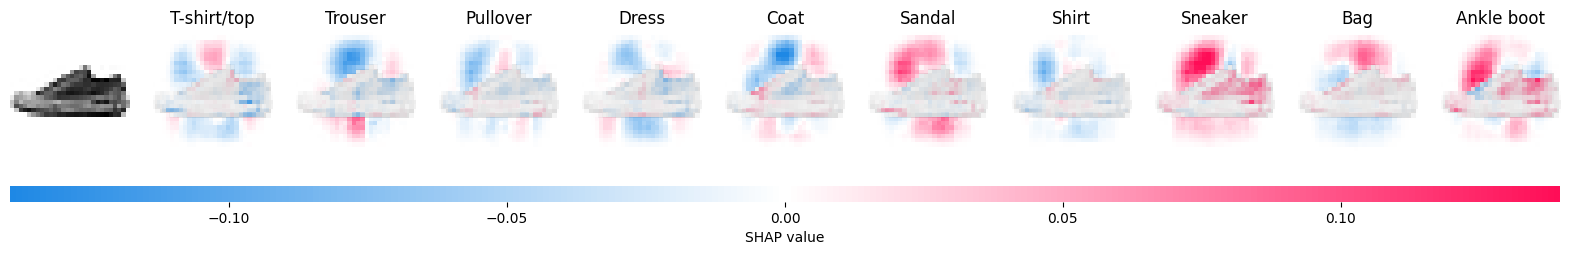

--------

Actual Class: Bag, Predicted Class: Bag, Predicted Probability: 0.3580

Prob for class T-shirt/top: 0.0434
Prob for class Trouser: 0.0001
Prob for class Pullover: 0.3103
Prob for class Dress: 0.0025
Prob for class Coat: 0.0310
Prob for class Sandal: 0.0000
Prob for class Shirt: 0.2548
Prob for class Sneaker: 0.0000
Prob for class Bag: 0.3580
Prob for class Ankle boot: 0.0000


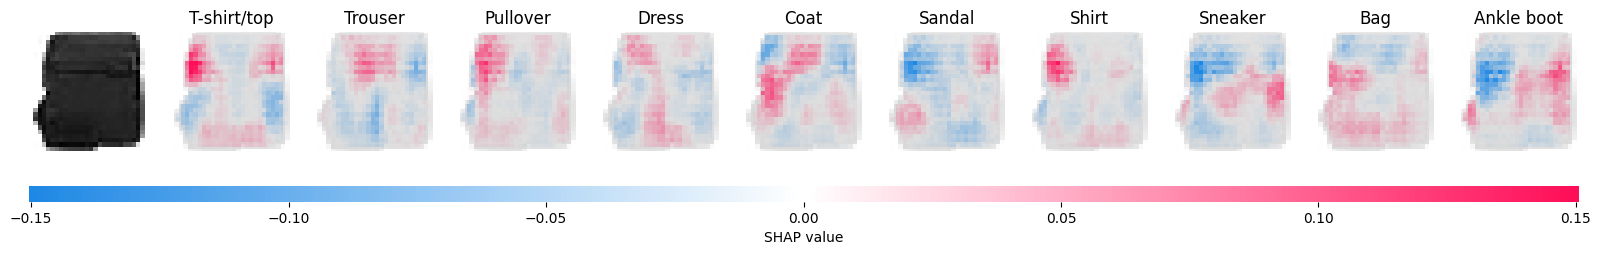

--------

Actual Class: Dress, Predicted Class: Dress, Predicted Probability: 0.8913

Prob for class T-shirt/top: 0.0321
Prob for class Trouser: 0.0061
Prob for class Pullover: 0.0038
Prob for class Dress: 0.8913
Prob for class Coat: 0.0024
Prob for class Sandal: 0.0000
Prob for class Shirt: 0.0641
Prob for class Sneaker: 0.0000
Prob for class Bag: 0.0002
Prob for class Ankle boot: 0.0000


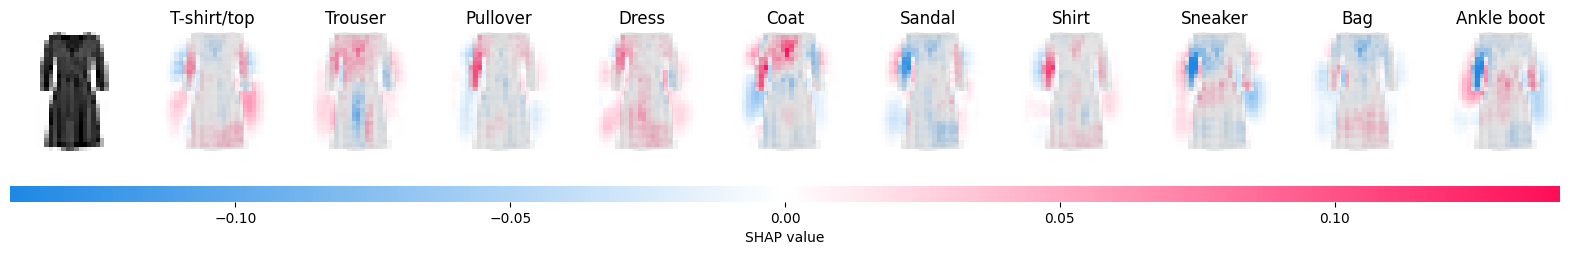

--------

Actual Class: T-shirt/top, Predicted Class: T-shirt/top, Predicted Probability: 0.6761

Prob for class T-shirt/top: 0.6761
Prob for class Trouser: 0.0003
Prob for class Pullover: 0.0030
Prob for class Dress: 0.0284
Prob for class Coat: 0.0001
Prob for class Sandal: 0.0000
Prob for class Shirt: 0.2919
Prob for class Sneaker: 0.0000
Prob for class Bag: 0.0002
Prob for class Ankle boot: 0.0000


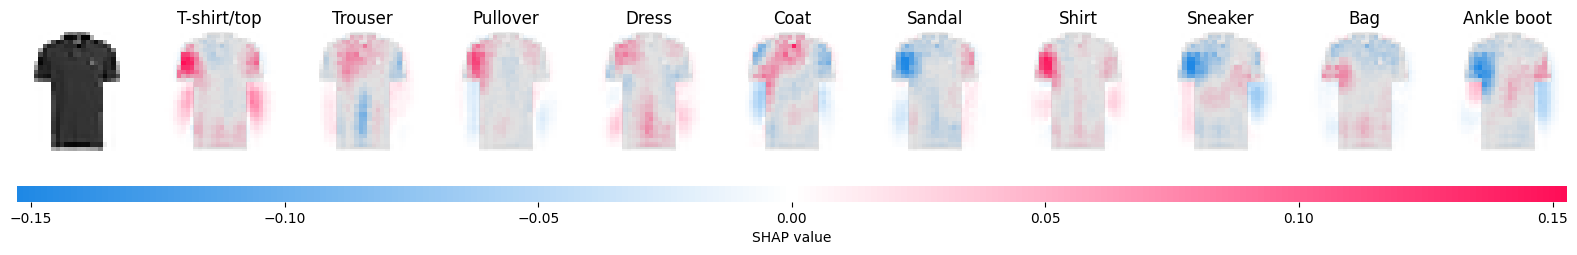

--------

Actual Class: Sneaker, Predicted Class: Sneaker, Predicted Probability: 0.9777

Prob for class T-shirt/top: 0.0000
Prob for class Trouser: 0.0000
Prob for class Pullover: 0.0000
Prob for class Dress: 0.0000
Prob for class Coat: 0.0000
Prob for class Sandal: 0.0212
Prob for class Shirt: 0.0000
Prob for class Sneaker: 0.9777
Prob for class Bag: 0.0004
Prob for class Ankle boot: 0.0008


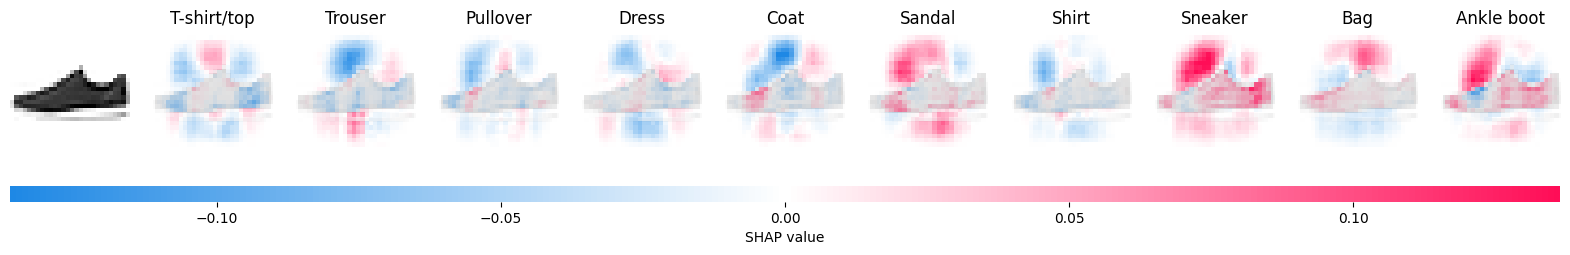

--------

Actual Class: T-shirt/top, Predicted Class: Bag, Predicted Probability: 0.6067

Prob for class T-shirt/top: 0.0145
Prob for class Trouser: 0.0001
Prob for class Pullover: 0.0243
Prob for class Dress: 0.0034
Prob for class Coat: 0.1901
Prob for class Sandal: 0.0000
Prob for class Shirt: 0.1609
Prob for class Sneaker: 0.0000
Prob for class Bag: 0.6067
Prob for class Ankle boot: 0.0000


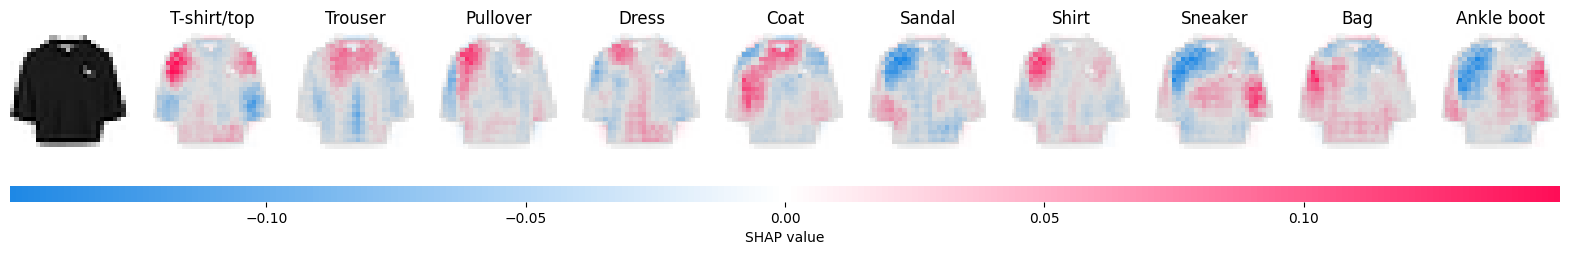

--------

Actual Class: Shirt, Predicted Class: Shirt, Predicted Probability: 0.5886

Prob for class T-shirt/top: 0.0163
Prob for class Trouser: 0.0053
Prob for class Pullover: 0.2141
Prob for class Dress: 0.0121
Prob for class Coat: 0.1122
Prob for class Sandal: 0.0285
Prob for class Shirt: 0.5886
Prob for class Sneaker: 0.0003
Prob for class Bag: 0.0224
Prob for class Ankle boot: 0.0002


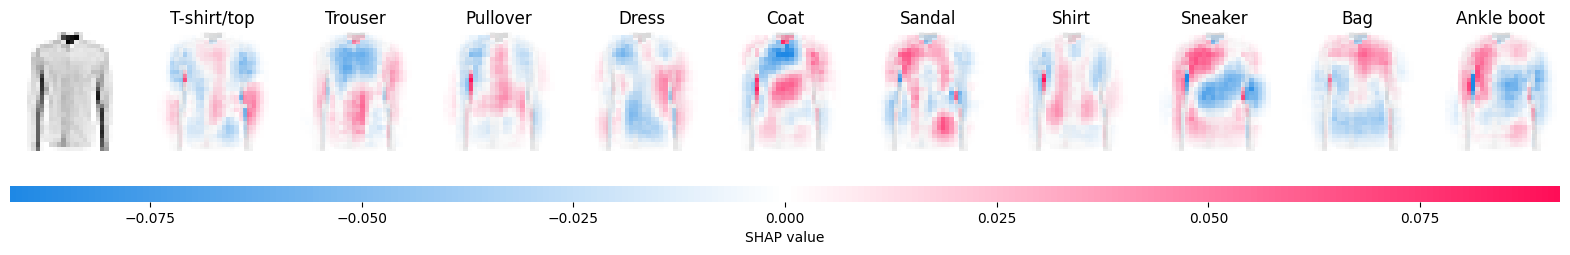

--------

Actual Class: Coat, Predicted Class: Pullover, Predicted Probability: 0.3550

Prob for class T-shirt/top: 0.0018
Prob for class Trouser: 0.0001
Prob for class Pullover: 0.3550
Prob for class Dress: 0.0028
Prob for class Coat: 0.3012
Prob for class Sandal: 0.0000
Prob for class Shirt: 0.3288
Prob for class Sneaker: 0.0000
Prob for class Bag: 0.0103
Prob for class Ankle boot: 0.0000


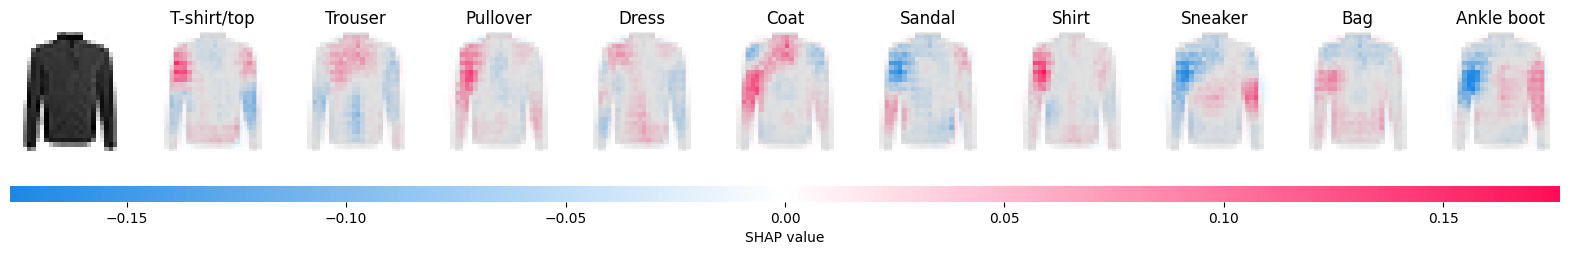

--------

Actual Class: Coat, Predicted Class: Shirt, Predicted Probability: 0.4166

Prob for class T-shirt/top: 0.0211
Prob for class Trouser: 0.0025
Prob for class Pullover: 0.0152
Prob for class Dress: 0.3497
Prob for class Coat: 0.1892
Prob for class Sandal: 0.0000
Prob for class Shirt: 0.4166
Prob for class Sneaker: 0.0000
Prob for class Bag: 0.0057
Prob for class Ankle boot: 0.0000


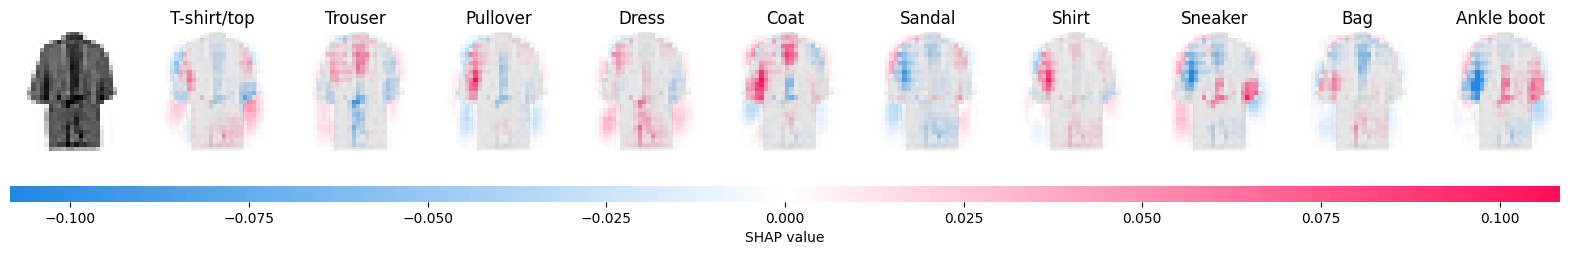

--------

Actual Class: Ankle boot, Predicted Class: Ankle boot, Predicted Probability: 0.9973

Prob for class T-shirt/top: 0.0000
Prob for class Trouser: 0.0000
Prob for class Pullover: 0.0000
Prob for class Dress: 0.0000
Prob for class Coat: 0.0000
Prob for class Sandal: 0.0009
Prob for class Shirt: 0.0000
Prob for class Sneaker: 0.0017
Prob for class Bag: 0.0001
Prob for class Ankle boot: 0.9973


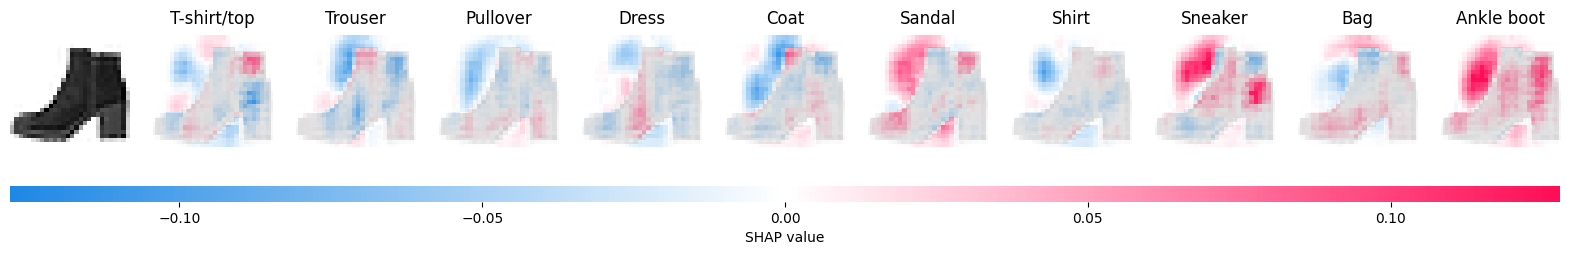

In [22]:
labels_dict = {
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot'
}

import shap 

batch = next(iter(test_loader))
images, labels = batch
images = images.view(-1, 1, 28, 28)

# choose random indices for the images
random.seed(0)
random_indices = random.sample(range(len(images)), 10)

# loop through the random indices and save the corresponding images & labels
imgs, lbls = [], []
for i, idx in enumerate(random_indices):
    # Access the image from the dataset along with its label
    imgs.append(images[idx])
    lbls.append(labels[idx])

background = images[:100]
test_images= images[100:110]
test_labels= labels[100:110]

# e = shap.DeepExplainer(model, images)
e = shap.DeepExplainer(model, background)

# for i in range(len(test_images)):
for i in range(len(imgs)):
#     test = test_images[i].view(-1, 1, 28, 28)
    test = imgs[i].view(-1, 1, 28, 28)
    shap_values = e.shap_values(test)

    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(test.numpy(), 1, -1), 1, 2)
    
    out = model(test) # Forward propagation
    predicted = torch.max(out.data, 1)[1] # Get predictions from the maximum value
    probs = F.softmax(out).detach()
    pred_probs = probs[range(len(predicted)), predicted] 
    
    print('--------\n')
    print("Actual Class: {}, Predicted Class: {}, Predicted Probability: {:.4f}\n".format(
#         labels_dict[test_labels[i].item()],
        labels_dict[lbls[i].item()],
        labels_dict[predicted.item()],
        pred_probs.item()
        
    ))
    
    for cls in labels_dict.keys():
        print('Prob for class {}: {:.4f}'.format(
            labels_dict[cls],
             probs[0][cls]))
    
    
    
    shap.image_plot(shap_numpy, -test_numpy, labels = list(labels_dict.values()))

### Questions

**Q 1.1 Explain the output. What is displayed and what does it mean?**

...

---
---

# 2. Gradient-based methods

In gradient-based attribution methods, the gradients of the output (logits or soft-max probabilities) with respect to the extracted features or the input are calculated via backpropagation and are used to estimate attribution scores. Several variations of gradient-based approaches exist attempting to reduce the noise in the resulting attribution maps.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

For loading the data and training the network, we loosely follow [this tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

## Load CIFAR10 dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# load data
trainset = torchvision.datasets.CIFAR10(root='../datasets', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../datasets', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

classes = {
    0:'plane',
    1:'car',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}

Files already downloaded and verified
Files already downloaded and verified


### inspecting the data

['frog', 'frog', 'deer', 'cat']


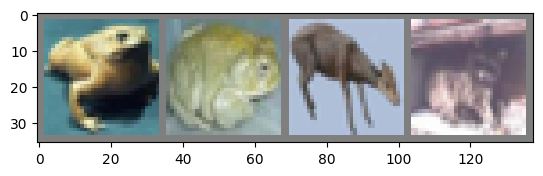

In [3]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

## visualise some examples fromthe training data
# print labels
print([classes[labels[j].item()] for j in range(batch_size)])
# show images
imshow(torchvision.utils.make_grid(images))

## Training a neural network 

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### training the model

### &#9888;&#65039; &#9888;&#65039; If the training process takes too long on your machine, you can load the trained model from the repo:

In [28]:
random_seed = 1
torch.manual_seed(random_seed)

# define your model
model = Net()

# define the optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# train model
for epoch in range(2):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 2000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, i * len(data), len(trainloader.dataset),
                100. * i / len(trainloader), loss.item()))

print('Finished Training')

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.322279
Train Epoch: 1 [4000/50000 (16%)]	Loss: 2.734238
Train Epoch: 1 [8000/50000 (32%)]	Loss: 1.229986
Train Epoch: 1 [12000/50000 (48%)]	Loss: 1.322733
Train Epoch: 1 [16000/50000 (64%)]	Loss: 1.517454
Train Epoch: 1 [20000/50000 (80%)]	Loss: 1.493416
Train Epoch: 1 [24000/50000 (96%)]	Loss: 1.007845
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.832871
Train Epoch: 2 [4000/50000 (16%)]	Loss: 0.487044
Train Epoch: 2 [8000/50000 (32%)]	Loss: 1.160645
Train Epoch: 2 [12000/50000 (48%)]	Loss: 2.076488
Train Epoch: 2 [16000/50000 (64%)]	Loss: 1.161965
Train Epoch: 2 [20000/50000 (80%)]	Loss: 1.028278
Train Epoch: 2 [24000/50000 (96%)]	Loss: 1.081116
Finished Training


In [29]:
# save the trained model if desired
# PATH = '../03_unboxing/models/cifar_net_trained.pth'
# torch.save(model.state_dict(), PATH)

### evaluating on the test set

In [5]:
# load the trained model if necessary
# PATH = '../03_unboxing/models/cifar_net_trained.pth'
# model = Net()
# model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [6]:
correct = 0
total = 0
model.eval()

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(testloader.dataset),
    100. * correct / len(testloader.dataset)))


Test set: Accuracy: 5575/10000 (56%)



### inspect prediction accuracy per class

In [7]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
            total_pred[label.item()] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classes[classname]:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 46.1 %
Accuracy for class: car   is 65.5 %
Accuracy for class: bird  is 55.3 %
Accuracy for class: cat   is 32.2 %
Accuracy for class: deer  is 38.3 %
Accuracy for class: dog   is 47.4 %
Accuracy for class: frog  is 71.5 %
Accuracy for class: horse is 53.5 %
Accuracy for class: ship  is 76.1 %
Accuracy for class: truck is 71.6 %


## Applying GradCAM

We are using the implementation from [this package](https://github.com/jacobgil/pytorch-grad-cam).

In [8]:
target_layer = model.conv2 # layer to visualize (last convolutional layer)

-------------------------------

Ground Truth: frog
Predicted: bird

Prob for class plane: 0.0042
Prob for class car: 0.0013
Prob for class bird: 0.3941
Prob for class cat: 0.0967
Prob for class deer: 0.1497
Prob for class dog: 0.0696
Prob for class frog: 0.2710
Prob for class horse: 0.0099
Prob for class ship: 0.0016
Prob for class truck: 0.0019


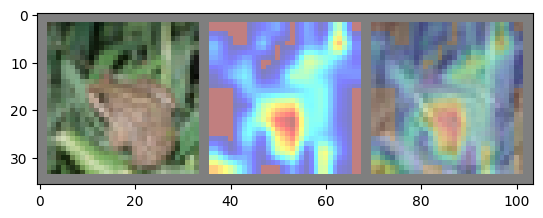

-------------------------------

Ground Truth: frog
Predicted: frog

Prob for class plane: 0.0232
Prob for class car: 0.0100
Prob for class bird: 0.1658
Prob for class cat: 0.0852
Prob for class deer: 0.0993
Prob for class dog: 0.0584
Prob for class frog: 0.4855
Prob for class horse: 0.0229
Prob for class ship: 0.0251
Prob for class truck: 0.0244


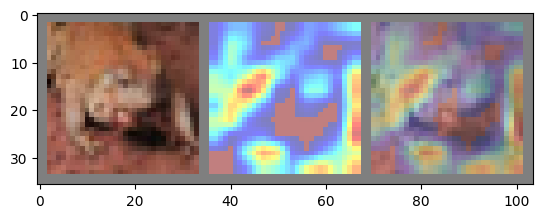

-------------------------------

Ground Truth: car
Predicted: car

Prob for class plane: 0.1447
Prob for class car: 0.3677
Prob for class bird: 0.1430
Prob for class cat: 0.0783
Prob for class deer: 0.0501
Prob for class dog: 0.0670
Prob for class frog: 0.0182
Prob for class horse: 0.0398
Prob for class ship: 0.0475
Prob for class truck: 0.0437


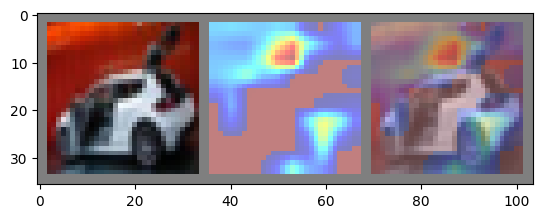

-------------------------------

Ground Truth: frog
Predicted: frog

Prob for class plane: 0.0118
Prob for class car: 0.0024
Prob for class bird: 0.2635
Prob for class cat: 0.0410
Prob for class deer: 0.0766
Prob for class dog: 0.0148
Prob for class frog: 0.5700
Prob for class horse: 0.0063
Prob for class ship: 0.0090
Prob for class truck: 0.0046


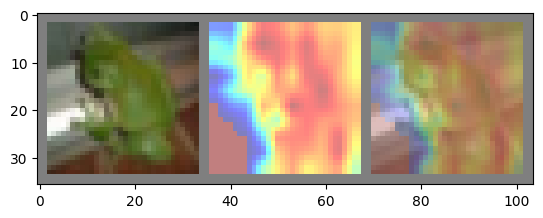

In [15]:
from pytorch_grad_cam import GradCAM
import cv2

# initialize the GradCAM instance with your model
gradcam = GradCAM(model=model, target_layers=[target_layer])

# get some images
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = next(dataiter)

# get predicted values
outputs = model(images)
_, predicted = torch.max(outputs, 1)
probs = F.softmax(outputs, dim=1)
probs

# compute the GradCAM heatmaps
cam_list = []

for i, image in enumerate(images):
    image.requires_grad_()
    grayscale_cam = gradcam(input_tensor=image.unsqueeze(0))
    cam_list.append(grayscale_cam)
    
    image = image.cpu().permute(1, 2, 0).detach().numpy()
    heatmap = cam_list[i][0]  # assuming you only have one heatmap for each image
    
    # resize heatmap to match image dimensions
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    
    # convert heatmap to 8-bit unsigned integer (CV_8UC1) (required to apply colormap)
    heatmap = (heatmap * 255).astype('uint8')
    heatmap = cv2.applyColorMap(1-heatmap, cv2.COLORMAP_JET) # apply colormap
    # normalize heatmap
    vmin = heatmap.min()
    vmax = heatmap.max()
    heatmap = (heatmap - vmin)/(vmax - vmin)

    # overlay heatmap on image
    overlaid_img = heatmap * 0.5 + image * 0.5   # adjust the weight for overlay

    print('-------------------------------\n')
    print(f'Ground Truth: {classes[labels[i].item()]}')
    print(f'Predicted: {classes[predicted[i].item()]}\n')
    
    for cls in classes.keys():
        print('Prob for class {}: {:.4f}'.format(
            classes[cls],
             probs[i][cls]))
        
    im_tensor = torch.tensor(image.transpose((2, 0, 1)))
    heat_tensor = torch.tensor(heatmap.transpose((2, 0, 1)))
    overlay = torch.tensor(overlaid_img.transpose((2,0,1)))
    imshow(torchvision.utils.make_grid([im_tensor, heat_tensor, overlay]))

### Questions

**Q 2.1 Explain the output.**

...

**Q 2.2 Evaluate the explanations given by Gradcam.**

... 